# Adversarial Attack

In [30]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import cv2
from PIL import Image
import pandas as pd
import itertools

In [32]:
# Metadaten für das Programm 
data = []
labels = []
height = 30
width = 30
channels = 3
classes = 43
input_size = height * width * channels

In [33]:
# Verkehrsschilder 
sign_label = ["20 km/h","30 km/h","50 km/h","60 km/h","70 km/h","80 km/h","80 km/h Aufhebung","100 km/h",
          "120 km/h", "Überholverbot", "LKW-Überholverbot", "Vorfahrt", "Vorfahrtsstraße","Vorfahrt gewähren", 
          "Stop","Fahrverbot","Verbot für Lastwagen","Einfahrt verboten","Gefahr","Linkskurve","Rechtskurve","Doppelkurve",
          "Bodenwelle","Schleudergefahr","Verengung","Baustelle","Ampel","Zebrastreifen","Kinder","Fahrradweg","Schneegefahr",
          "Wildwechsel","Unbegrenzte Geschwindigkeit","Rechtsabbiegen", "Linksabbiegen", "Geradeaus fahren", "Geradeaus oder Rechtsabbiegen",
          "Geradeaus oder Linksabbiegen", "Hindernis rechts umfahren", " Hindernis links umfahren", "Kreisverkehr", "Ende des Überholverbotes",
          "Ende des LKW-Überholverbotes"]

In [34]:
# Laden der Test-Daten CSV
def load_test_data(height=30, width=30):
    y_test = pd.read_csv(r'./Data/Test.csv', ";")
    names = y_test['Filename'].to_numpy()
    y_test = y_test['ClassId'].values
    data = []
    for name in names:
        image = cv2.imread(r'./Data/Test/' + name.replace('Test', ''))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((height, width))
        data.append(np.array(size_image))

    return data, y_test

data, y_test = load_test_data()

#y_test=pd.read_csv(r'.\Data\Test.csv')
#names =y_test['Path'].to_numpy()
#y_test =y_test['ClassId'].values
#data=[]

/var/folders/78/1bng90q94y76s663_g_194zc0000gn/T/ipykernel_12401/1456208092.py:16: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  data, y_test = load_test_data()


In [35]:
# Laden der Test-Daten Bilder
#from tqdm import tqdm
#for f in tqdm(names):
#    image=cv2.imread(r'.\Data\Test/'+f.replace('Test', ''))
#    image_from_array = Image.fromarray(image, 'RGB')
#    size_image = image_from_array.resize((height, width))
#    data.append(np.array(size_image))

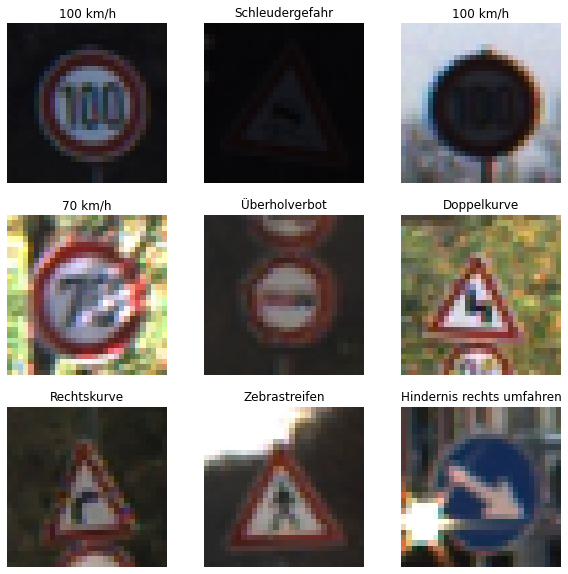

In [36]:
# Beispiele aus dem Test Dataset
fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 3

for i in range(1, columns*rows +1):
    x = i+10
    fig.add_subplot(rows, columns, i)
    plt.imshow(data[x])
    plt.title(sign_label[y_test[x]])
    plt.axis("off")
plt.show()

In [37]:
model = keras.models.load_model("Traffic_Sign_Net")

In [38]:
x_test=np.array(data)
x_test = x_test.astype('float32')/255
pred = model.predict(x_test)
print("Anzahl der Predictions:",len(pred),"/",len(x_test))

2022-08-08 09:47:12.689328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Anzahl der Predictions: 12630 / 12630


# Attacke FGSM

In [52]:
# Funktion um ein adversarial_pattern zu erstellen
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    #print(loss)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

tf.Tensor([7.16069e-08], shape=(1,), dtype=float32)


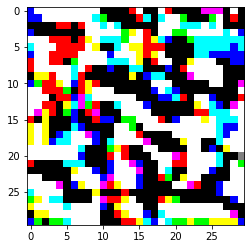

In [53]:
# Darstellung des Patterns 
i = 408 #408, 7, 10, 14

image = x_test[i]
image = image.reshape(1, height, width, channels)
image = tf.cast(image, tf.float32)

image_label = y_test[i] # y_test[i]
image_probs = model.predict(image)

label = tf.one_hot(image_label, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = adversarial_pattern(image, label)
#print(perturbations)
plt.imshow(perturbations[0]*0.5+0.5); # To change [-1, 1] to [0,1]

In [44]:
max_iterations = 0.99
confidence = 0.9

for x in np.arange(0.0, max_iterations, 0.001):
    
    adversarial = image + perturbations * x 
    
    original_prediction = sign_label[model.predict(image).argmax()]
    adversarial_prediction = sign_label[model.predict(adversarial).argmax()]
    
    print("Noise:", round(x,3), 
          "\t Confidence",round(max(model.predict(adversarial)[0]), 3),
          "\t Prediction",adversarial_prediction)
    
    if original_prediction != adversarial_prediction and \
    max(model.predict(adversarial)[0]) > confidence:
        noise = x
        break
    else:
        noise = x    

Noise: 0.0 	 Confidence 0.999 	 Prediction 80 km/h
Noise: 0.001 	 Confidence 0.996 	 Prediction 80 km/h
Noise: 0.002 	 Confidence 0.985 	 Prediction 80 km/h
Noise: 0.003 	 Confidence 0.95 	 Prediction 80 km/h
Noise: 0.004 	 Confidence 0.87 	 Prediction 80 km/h
Noise: 0.005 	 Confidence 0.705 	 Prediction 80 km/h
Noise: 0.006 	 Confidence 0.529 	 Prediction 60 km/h
Noise: 0.007 	 Confidence 0.752 	 Prediction 60 km/h
Noise: 0.008 	 Confidence 0.887 	 Prediction 60 km/h
Noise: 0.009 	 Confidence 0.951 	 Prediction 60 km/h


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


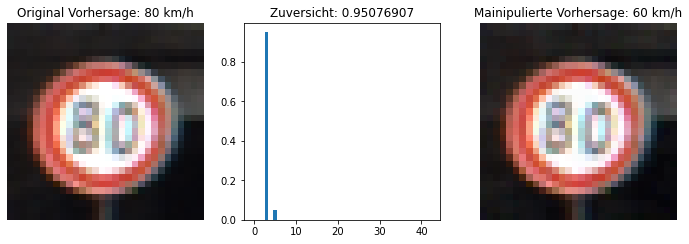

In [45]:
# Ergebnisse der Attacke darstellen
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (12, 12))

y = [i for i in range(len(sign_label))]

ax1.imshow(image[0])
ax2.bar(y, model.predict(adversarial)[0])
ax3.imshow(adversarial[0])

asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
ax2.set_aspect(asp)

ax1.axis("off")
ax3.axis("off")

ax1.title.set_text("Original Vorhersage: "+str(original_prediction))
ax2.title.set_text("Zuversicht: "+ str(max(model.predict(adversarial)[0])))
ax3.title.set_text("Mainipulierte Vorhersage: " + str(adversarial_prediction))
plt.show()

# Rescaling

In [46]:
def rescaler(image, size):
    image_reshaped = image.reshape(height, width, channels)
    image_from_array = Image.fromarray(image_reshaped, 'RGB')
    size_image = image_from_array.resize((size, size))
    image_array = np.array(size_image)
    return image_array

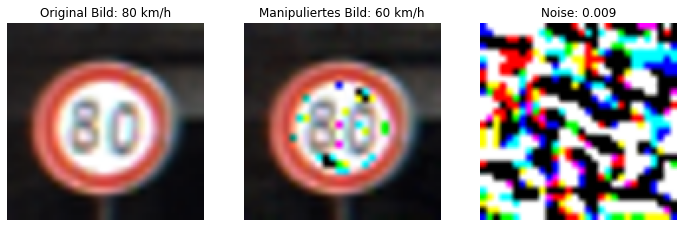

In [47]:
# Ergebnisse der Attacke darstellen
adversarial_image = adversarial.numpy()
adversarial_image = adversarial_image * 255
adversarial_image = adversarial_image.astype('uint8')
adversarial_image = rescaler(adversarial_image, 100)

perturbations_pattern = perturbations.numpy()
perturbations_pattern = perturbations_pattern * 255
perturbations_pattern = perturbations_pattern.astype('uint8')
perturbations_pattern = rescaler(perturbations_pattern, 100)

original_image = image.numpy()
original_image = original_image * 255
original_image = original_image.astype('uint8')
original_image = rescaler(original_image, 100)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (12, 12))

ax1.imshow(original_image)
ax2.imshow(adversarial_image)
ax3.imshow(perturbations_pattern)

ax1.axis("off")
ax2.axis("off")
ax3.axis("off")

ax1.title.set_text("Original Bild: "+str(original_prediction))
ax2.title.set_text("Manipuliertes Bild: "+ str(adversarial_prediction))
ax3.title.set_text("Noise: " + str(round(noise,3)))
plt.show()

# Downscaling

In [48]:
def downscaler(image):
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((height, width))
    array_image = np.array(size_image)
    array_image = array_image.astype('float32')/255
    array_image = array_image.reshape(1, height, width, channels)
    return array_image


Vorhersage für das neu skallierte Bild: 80 km/h


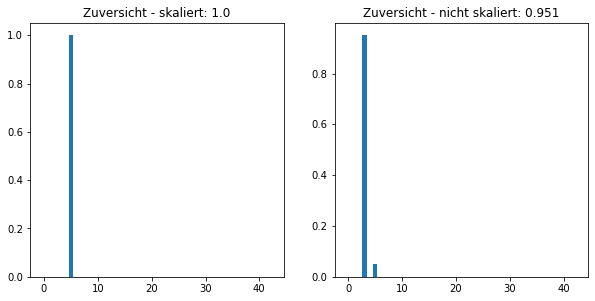

In [49]:
adversarial_down_image = downscaler(adversarial_image)
print("Vorhersage für das neu skallierte Bild:",\
      sign_label[model.predict(adversarial_down_image).argmax()])

fig, (ax1, ax2 ) = plt.subplots(1,2,figsize = (10, 10))
ax1.bar(y, model.predict(adversarial_down_image)[0])
ax2.bar(y, model.predict(adversarial)[0])

asp = np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0]
ax1.set_aspect(asp)
asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
ax2.set_aspect(asp)

ax1.title.set_text("Zuversicht - skaliert: "+ str(round(max(model.predict(adversarial_down_image)[0]),3)))
ax2.title.set_text("Zuversicht - nicht skaliert: "+ str(round(max(model.predict(adversarial)[0]),3)))

plt.show()

# Gesamt Attacke

In [50]:
# Funktion zum manipulieren des Datensets

def giant_attack(dataset_images, dataset_labels, iterations = False, max_iterations = 0.03, confidence = 0.9):
    
    attacked_dataset = []
    
    for i in tqdm(range(len(dataset_images))):
        image = dataset_images[i]
        image = image.reshape(1, height, width, channels)

        image_label = dataset_labels[i]
        image_probs = model.predict(image)

        label = tf.one_hot(image_label, image_probs.shape[-1])
        label = tf.reshape(label, (1, image_probs.shape[-1]))

        perturbations = adversarial_pattern(image, label)

        if iterations:
            for x in np.arange(0.0, max_iterations, 0.001):

                adversarial = image + perturbations * x
                adversarial = tf.clip_by_value(adversarial, -1, 1)

                original_prediction = sign_label[model.predict(image).argmax()]
                adversarial_prediction = sign_label[model.predict(adversarial).argmax()]

                if original_prediction != adversarial_prediction and \
                    max(model.predict(adversarial)[0]) > confidence:
                    noise = x
                    break
        else:
            adversarial = image + perturbations * max_iterations
            adversarial = tf.clip_by_value(adversarial, -1, 1)
            
        attacked_dataset.append(np.array(adversarial))
        
    return attacked_dataset

In [51]:
attacked_dataset = giant_attack(x_test, y_test, max_iterations = 0.03 )

TypeError: 'module' object is not callable

NameError: name 'attacked_dataset' is not defined

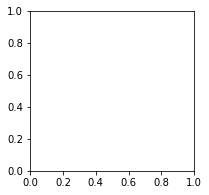

In [22]:
# Beispiele aus dem Attacked Dataset
fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 3

for i in range(1, columns*rows +1):
    x = i+100
    fig.add_subplot(rows, columns, i)
    plt.imshow(attacked_dataset[x][0])
    plt.title(sign_label[y_test[x]])
    plt.axis("off")
plt.show()

In [25]:
adversarial_predictions = []
attacked_dataset=np.array(attacked_dataset)

for i in tqdm(range(len(attacked_dataset))):
    attacked_pred = model.predict(attacked_dataset[i])
    adversarial_predictions.append(attacked_pred.argmax())

100%|██████████| 12630/12630 [03:57<00:00, 53.22it/s]


In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [27]:
cm = confusion_matrix(y_test, adversarial_predictions)

In [28]:
df_cm = pd.DataFrame(cm, index = [i for i in sign_label],
                          columns = [i for i in sign_label])

df_perc = pd.DataFrame()
for i in sign_label:
    row = (df_cm[i] / df_cm[i].sum()) * 100
    df_perc = pd.concat([df_perc, round(row,1)],axis=1)

In [24]:
df_perc.round(0)
plt.figure(figsize = (20,20))
svm = sn.heatmap(df_perc, annot=True,vmin=0, vmax=100)
figure = svm.get_figure() 
figure.savefig('.\Images\cm_adversarial_percentage_test.png', dpi=400)

NameError: name 'df_perc' is not defined

In [33]:
overall = 0

for i in df_perc:
    overall += df_perc[i][i]

print(overall/43)

41.7860465116279
